# MA - INF 2201 - Computer Vision WS 22/23

### Exercise Sheet 04


In [1]:
import matplotlib.pyplot as plt
import numpy.linalg as la
from matplotlib import rc
import numpy as np
import cv2

**1.**

Read the images ball.png and coffee.png and segment the object in both images
using snakes. 

Initialize the snake by a circle around the object and optimize it
using dynamic programming. 

The elastic term should be used as pairwise cost, penalizing deviation from the average distance between pairs of nodes. 

Visualize for both images how the snake converges to the boundary of the object.

(10 Points)

In [150]:

# is the internal energy
def compute_graph_dist_mean(V):
    distances = []
    for (y1,x1), (y2,x2) in zip(V, V[1:-1]):
        distances.append(np.sqrt((x1-x2)**2 + (y1-y2)**2))
    return distances, np.mean(distances)

def euclid_arr(P, U, k):
    # loop over each vertex pair
    for v_idx in range(1, U.shape[0]):
        # loop over neighborhood or former vertex (from top left to bottom, left to right 1-kxk neighborhood)
        for neigh in range(k*k):
            # get idx of former vertex array
            idx_y = neigh % k
            idx_x = neigh // k
            # from former vertex arr save euclid distance 
            for i in range(k):
                for j in range(k):
                    # compute euclid distanced in a 3x3 for a former vertex 
                    P[v_idx - 1, neigh] = np.sqrt(
                        (U[v_idx-1, 1, i, j] - U[v_idx, 1])**2 # y dim
                        + (U[v_idx-1, 2, i, j] - U[v_idx, 2])**2 # x dim
                        )

    return P

        

def elastic_energy(P, U, k, old_avg, alpha=1):
    new_P = np.array(euclid_arr(P, U, k))
    elastic = alpha * (new_P - old_avg)**2
    return elastic

def magnitude_img(image):
    # already grayscale given
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = grad_x**2 + grad_y**2
    return magnitude

def min_total_energy(V, U, P, k):
    V_size = len(V)
    # one extra dim to save the prior node vals for backtracking, v_size 
    # third dim: (etotal val, x, y, neighbor_idx, i, j of prev vertex)
    e_total = np.zeros((V_size, k * k, 6, k, k))

    # we can set the first node total energy to its external energy by default
    U_reshaped = U.reshape(V_size, 3, -1)
    # expand dims to set to every entry of total energy 
    U_reshaped_expanded = np.expand_dims(U_reshaped[0], axis=(0, 3, 4))


    # save first magnitude values as total values
    e_total[0, :, 0, :, :] = U_reshaped_expanded[0, 0, :, :, :]
    # create a link to themselves, just in case
    e_total[0, :, (1, 2), :, :] = (U_reshaped_expanded[0, 1, :, :, :], U_reshaped_expanded[0, 2, :, :, :])

    # can't use numpy.min for min computation, since we need to backtrack as well 
    # keep node information in second e_total dim
    # Forward Step:
    # U.shape = (V.shape[0], 3, k, k), P.shape = (V.shape[0] - 1, k*k, k, k)
    for v_idx in range(1, V_size):
        # loop over neighborhood
        for neigh_i in range(k*k):
            # loop over all connections
            for e_i in range(k):
                for e_j in range(k): 
                    # compute values, e_i, e_j loop over pairwise and unary values
                    # e_total is the same value for all entries, but inefficiently written
                    e_total[v_idx, neigh_i, 0, e_i, e_j] = (
                        e_total[v_idx - 1, neigh_i, 0, e_i, e_j] # former min energy total
                        + P[v_idx - 1, neigh_i, e_i, e_j] # internal energy
                        + U[v_idx, 0, e_i, e_j] # external energy
                    )
                    e_total[v_idx, neigh_i, (1, 2), e_i, e_j] = U[v_idx, (1,2), e_i, e_j]
                    e_total[v_idx, neigh_i, (3, 4, 5), e_i, e_j] = (neigh_i, e_i, e_j)
            # set all entries to minimum:
            argmin = np.where(e_total[v_idx, neigh_i, 0] == e_total[v_idx, neigh_i, 0].min())
            # check for duplicates in the minimum value
            if len(argmin[0]):
                argmin = argmin[0][0], argmin[1][0]
            e_total[v_idx, neigh_i, (0, 1, 2, 3, 4, 5)] = np.expand_dims(e_total[v_idx, neigh_i, (0, 1, 2, 3, 4, 5), argmin[0], argmin[1]], axis=(1, 2))


    # Backtracking:
    # e_total.shape = (V_size, k * k, 6, k, k)
    # third dim: (etotal val, x, y, neighbor_idx, i, j of prev vertex)
    argmin_total = np.where(e_total[-1] == e_total[-1].min())
    # print(argmin_total)
    # print(e_total[-1].shape)
    # print(e_total[-1, argmin_total[0], 0])
    # print(e_total[-1, argmin_total[0], 3, 0, 0])
    # print(e_total[-1, :, 0])
    V_new = V.copy()
    for i in reversed(range(2, V_size+1)):  
        argmin_total = np.where(e_total[-i] == e_total[-i].min())
        neigh_node = argmin_total[0]
        idx_i = neigh_node // 3
        idx_j = neigh_node % 3
        coords = np.array((e_total[-i, idx_i, 1, 0, 0], e_total[-i, idx_j, 2, 0, 0]))[:, 0]
        # print(coords.shape)
        # print("new coords", coords)
        # print("olrd coords", V[-i])
        V_new[-i] = coords
        # print(e_total[i-1, ])



    return V_new    
 


def snake_step(V, U, P, k, magnitude):
    # take minus of magnitude image for external energy
    external_energy = -magnitude
    # iterate over every vertex in V and set the external energy for each entry in U 
    # save coords as well for distance computation 
    for v_idx, (y, x) in enumerate(V):
        # get idx of 8 neighborhood
        for i in range(k):
            for j in range(k):
                # set external energy from former -magnitude calculation
                U[v_idx, 0, i, j] = external_energy[y - 1 + i, x - 1 + j]
                # save y and x coords
                U[v_idx, 1, i, j] = y - 1 + i
                U[v_idx, 2, i, j] = x - 1 + j


    old_dist, old_avg = compute_graph_dist_mean(V)
    new_P = elastic_energy(P, U, k, old_avg)


    V_new = min_total_energy(V, U, new_P, k)
    return V_new



[[199 229 256 282 300 313 318 317 309 292 271 245 216 185 156 129 107  91
   81  80  84  99 118 143 170]
 [370 365 354 338 313 287 258 228 199 174 153 138 131 131 139 152 172 199
  227 258 288 315 338 354 366]]


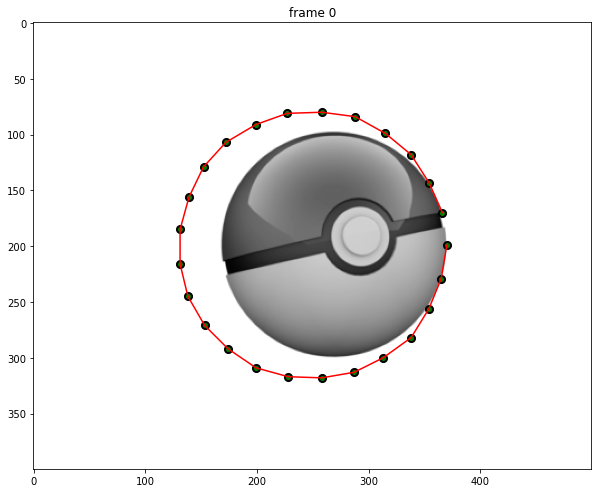

[[198 229 255 282 300 312 317 316 310 293 271 246 217 186 157 129 106  91
   81  79  84 100 119 143 170]
 [370 365 353 338 314 286 258 229 200 175 154 139 131 132 140 151 171 198
  228 258 289 315 339 353 366]]
[[197 229 254 281 300 312 316 315 309 294 272 247 218 187 158 130 106  90
   81  79  83 100 119 143 170]
 [370 365 353 337 314 287 257 229 201 176 155 138 132 132 141 152 170 197
  227 259 289 316 340 353 366]]
[[196 229 254 280 299 312 316 314 308 293 273 248 219 188 159 131 106  90
   80  79  83 101 119 143 170]
 [370 365 353 337 313 287 258 228 201 177 156 139 131 133 141 153 170 196
  226 258 290 315 341 353 366]]
[[195 229 254 280 298 311 316 314 307 292 272 249 220 189 160 132 107  90
   80  78  83 101 119 143 170]
 [370 365 353 337 313 286 258 229 200 177 157 140 132 132 142 153 171 196
  225 257 289 316 341 353 366]]
[[194 229 254 279 299 310 315 315 307 291 271 249 221 190 161 133 108  90
   80  79  82 101 120 143 170]
 [370 365 353 336 314 286 257 229 201 176 157 140 1

In [153]:
def plot_snake(ax, V, fill='green', line='red', alpha=1, with_txt=False):
    """ plots the snake onto a sub-plot
    :param ax: subplot (fig.add_subplot(abc))
    :param V: point locations ( [ (x0, y0), (x1, y1), ... (xn, yn)]
    :param fill: point color
    :param line: line colo'r
    :param alpha: [0 .. 1]
    :param with_txt: if True plot numbers as well
    :return:
    """
    # changed from original as well, such that dim1=x, dim2=y
    #V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.plot(V[:,1], V[:,0], color=line, alpha=alpha)
    ax.scatter(V[:,1], V[:,0], color=fill,
               edgecolors='black',
               linewidth=2, s=50, alpha=alpha)
    if with_txt:
        for i, (x, y) in enumerate(V):
            ax.text(x, y, str(i))


def load_data(fpath, radius):
    """
    :param fpath:
    :param radius:
    :return:
    """
    Im = cv2.imread(fpath, 0)
    h, w = Im.shape
    n = 25  # number of points
    u = lambda i: radius * np.cos(i) + w / 2
    v = lambda i: radius * np.sin(i) + h / 2
    # changed v and u from original to keep dim1=y, dim2=x 
    V = np.array(
        [(v(i), u(i)) for i in np.linspace(0, 2 * np.pi, n + 1)][0:-1],
        'int32')

    return Im, V


def run(fpath, radius):
    """ run experiment
    :param fpath:
    :param radius:
    :return:
    """
    Im, V = load_data(fpath, radius)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    n_steps = 100

    # set filter neighborhoodsize:
    k = 3

    # unary array: for each vertex save neighborhood and coords(y dim x dim)
    unary = np.zeros((V.shape[0], 3, k, k))
    # pairwise for each vertex save neighborhood and it's distances to the next vertex neighborhood
    pairwise = np.zeros((V.shape[0] - 1, k*k, k, k))

    magnitude_im = magnitude_img(Im)


    for t in range(n_steps):
        # unary array: for each vertex save neighborhood and coords(y dim x dim)
        unary = np.zeros((V.shape[0], 3, k, k))
        # pairwise for each vertex save neighborhood and it's distances to the next vertex neighborhood
        pairwise = np.zeros((V.shape[0] - 1, k*k, k, k))

        V = snake_step(V, unary, pairwise, k, magnitude_im)
        print(V.T)

        ax.clear()
        ax.imshow(Im, cmap='gray')
        ax.set_title('frame ' + str(t))
        plot_snake(ax, V)
        plt.pause(0.01)

    plt.pause(2)


if __name__ == '__main__':
    run('images/ball.png', radius=120)
    #run('images/coffee.png', radius=100)


**2.**

Read the image ball.png, resize it to half the size, and segment the object in the
image using level-sets with an geodesic active contour. 

Initialize the contour by a circle around the object and compute a signed distance transform to initialize the
level-set function. 

Optimize the geodesic contour by gradient descent.

Visualize for the image how the level-set function changes and how the contour converges to the
boundary of the object.

The proposed metric in geodesic active contours is:

$$
w(| \nabla I |) = \frac{I}{| \nabla I | + 1}
$$

(10 Points)

In [ ]:
rc('text', usetex=True)  # if you do not have latex installed simply uncomment this line + line 75


def load_data():
    """ loads the data for this task
    :return:
    """
    fpath = 'images/ball.png'
    radius = 70
    Im = cv2.imread(fpath, 0).astype('float32')/255  # 0 .. 1

    # we resize the image to speed-up the level set method
    Im = cv2.resize(Im, dsize=(0, 0), fx=0.5, fy=0.5)

    height, width = Im.shape

    centre = (width // 2, height // 2)
    Y, X = np.ogrid[:height, :width]
    phi = radius - np.sqrt((X - centre[0]) ** 2 + (Y - centre[1]) ** 2)

    return Im, phi


def get_contour(phi):
    """ get all points on the contour
    :param phi:
    :return: [(x, y), (x, y), ....]  points on contour
    """
    eps = 1
    A = (phi > -eps) * 1
    B = (phi < eps) * 1
    D = (A - B).astype(np.int32)
    D = (D == 0) * 1
    Y, X = np.nonzero(D)
    return np.array([X, Y]).transpose()

# ===========================================
# RUNNING
# ===========================================

# FUNCTIONS
# ------------------------
# your implementation here

# ------------------------


if __name__ == '__main__':

    n_steps = 20000
    plot_every_n_step = 100

    Im, phi = load_data()

    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # ------------------------
    # your implementation here

    # ------------------------

    for t in range(n_steps):

        # ------------------------
        # your implementation here

        # ------------------------

        if t % plot_every_n_step == 0:
            ax1.clear()
            ax1.imshow(Im, cmap='gray')
            ax1.set_title('frame ' + str(t))

            contour = get_contour(phi)
            if len(contour) > 0:
                ax1.scatter(contour[:, 0], contour[:, 1], color='red', s=1)

            ax2.clear()
            ax2.imshow(phi)
            # ax2.set_title(r'$\phi$', fontsize=22)
            plt.pause(0.01)

    plt.show()


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1152x576 with 2 Axes>